In [1]:
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import circle_fit as cf
import numpy as np
import time
import math
import random
import cv2
import os
%run ../functions.ipynb

## Error functions

In [36]:
def linear_ls_errors(x, y, a, b, weights):
    return (a*x - y + b)**2 * weights


def circle_ls_errors(x, y, a, b, r, weights):
    return ((x - a)**2 + (y - b)**2 - r**2)**2 * weights

## Fitting models

In [62]:
def linear_fit_model(error_func, init_cond, x, y, weights):
    J = lambda param: np.sum(error_func(x, y, param[0], param[1], weights))
    sol = minimize(J, init_cond)
    return sol

def circle_fit_model(error_func, init_cond, x, y, weights):
    J = lambda param: np.sum(error_func(x, y, param[0], param[1], param[2], weights))
    sol = minimize(J, init_cond)
    return sol

## RANSAC

### Bayesian based

In [34]:
def robust_lsq_ransac(error_func, fit_model, data, iterations=1000,
                      fit_samples=2, fit_with_best_n=None, priors=None, norm_func=np.arctan):
    
    # Step1. 事先機率設定
    
    # 1-1 如過參數 priors 為 None 時，將其設為全都一樣
    if priors == None:
        prob = np.ones(len(X))
    else:
        prob = priors
    
    # 1-2 將機率單位化
    prob = np.divide(prob, np.sum(prob)) # p /= sum(p)
    indices = np.array(range(len(X)))
    current_prob = prob.copy()
    
    
    # Step2. 計算穩定可靠的權重
    for iter in range(iterations):       
        # 2-1 隨機挑選 n 個資料子集合的索引
        sampled_indices = np.random.choice(range(len(indices)), 
                                          p=prob, size=fit_samples, replace=False)
        # 2-2 從完整資料及中取出相對應元素
        X_subset = X[sampled_indices]
        
        # 2-3 用計算取出的子集合求一組權重，再以此權重套到完整資料集求錯誤值
        params = fit_model(X_subset)
        errors = error_func(X, params)
        
        # 2-4 每次更新幅度與當次各點的誤差值成反比（不完全反比），含意為提高 inlier 往後被選取的機率
        current_prob[:] = 1 / norm_func(1 + errors[:]) 
        prob = np.multiply(prob, current_prob)            # p *= p'
        prob = np.divide(prob, np.sum(prob))     # p /= sum(p)
    
    
    # Step3. 如果參數 fit_with_best_n 沒給就只回傳每個點被選取的機率，若有則回傳前 n 個機率高的資料擬合結果
    if fit_with_best_n == None:       
        return prob
    else:
        robust_X = X[np.argsort(prob)[-fit_with_best_n:]]
        robust_params = fit_model(robust_X)
        latest_errors = error_func(robust_X, robust_params) 
        return prob, robust_params, latest_errors
        

## Test RANSAC

### linear

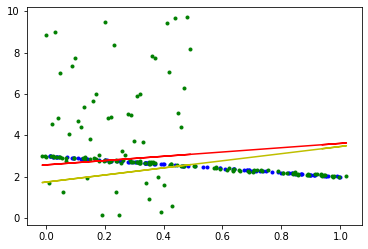

In [37]:
# Step1. 產生測試資料
x_actual = np.random.rand(100)
y_actual = x_actual * (-1) + 3
y_measured = y_actual + np.random.rand(len(x_actual)) * 0.1 - 0.05
x_measured = x_actual + np.random.rand(len(x_actual)) * 0.1 - 0.05
x_measured = np.append(x_measured, np.array(range(50)) / 100.0)
y_measured = np.append(y_measured, np.zeros(50) + np.random.rand(50) * 10)

# Step2. 
X = np.transpose([x_measured, y_measured])
weights = np.ones(len(X))

fit_func = lambda X: linear_fit_model(linear_ls_errors, [1,1], X[:,0], X[:,1], np.ones(len(X))).x
error_func = lambda X, params: linear_ls_errors(X[:,0],X[:,1],params[0],params[1],np.ones(len(X)))

# Step3. 分別用 LS 與 RANSAC 擬合
sol_lsq = linear_fit_model(linear_ls_errors, [1, 1], x_measured, y_measured,weights)
probs,params,errors = robust_lsq_ransac(error_func, fit_func,X,
                                 iterations = 100,fit_samples = 10,fit_with_best_n = 100)

plt.plot(x_actual, y_actual, '.b')
plt.plot(x_measured, y_measured, '.g')
plt.plot(x_measured, x_measured * sol_lsq.x[0] + sol_lsq.x[1], 'r')
plt.plot(x_measured, x_measured * params[0] + params[1], 'y')
plt.show()

### Circle

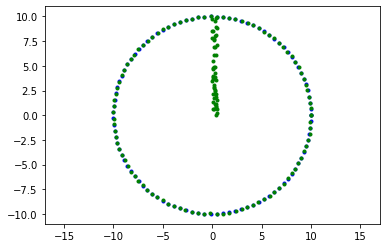

In [61]:
# Step1. 產生測試資料

# 1-1 生成圓形資料點
num_samples = 100
theta = np.linspace(0, 2*np.pi, num_samples)
r = np.random.rand((num_samples))

x_actual = 10 * np.cos(theta)
y_actual = 10 * np.sin(theta)
x_measured = x_actual + np.random.rand(len(x_actual)) * 0.1 - 0.05
y_measured = y_actual + np.random.rand(len(x_actual)) * 0.1 - 0.05
x_measured = np.append(x_measured, np.array(range(50)) / 100.0)
y_measured = np.append(y_measured, np.zeros(50) + np.random.rand(50) * 10)

# Step2. 
X = np.transpose([x_measured, y_measured])
weights = np.ones(len(X))

fit_func = lambda X: fitting_model(circle_ls_errors, [1,1], X[:,0], X[:,1], np.ones(len(X))).x
error_func = lambda X, params: circle_ls_errors(X[:,0],X[:,1],params[0],params[1],np.ones(len(X)))

plt.axis('equal')
plt.plot(x_actual, y_actual, '.b')
plt.plot(x_measured, y_measured, '.g')
plt.Circle((params[0], params[1]), 10)
# plt.plot(x_measured, x_measured * sol_lsq.x[0] + sol_lsq.x[1], 'r')
# plt.plot(x_measured, x_measured * params[0] + params[1], 'y')
plt.show()

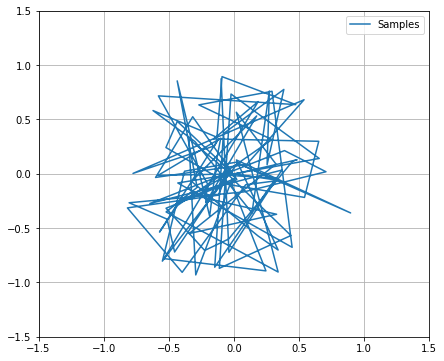

In [56]:
import numpy as np 
import pylab as plt 


num_samples = 100

# make a simple unit circle 
theta = np.linspace(0, 2*np.pi, num_samples)
a, b = 1 * np.cos(theta), 1 * np.sin(theta)


# generate the points
theta = np.random.rand((num_samples)) * (2 * np.pi)
r = np.random.rand((num_samples))
x, y = r * np.cos(theta), r * np.sin(theta)

# plots
plt.figure(figsize=(7,6))
plt.plot(a, b, linestyle='-', linewidth=2, label='Circle')
plt.plot(x, y, marker='o', linestyle='.', label='Samples')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.grid()
plt.legend(loc='upper right')
plt.show(block=True)

## M-Eestimator

In [ ]:
def robust_lsq_m_estimates(error_func, fitting_model, data,
                           iterations=1000, priors=None, norm_func=lambda x: 1/(1 + x**0.1)):

    # Step1. 事先機率設定

    # 1-1 如過參數 priors 為 None 時，將其設為全都一樣
    if priors == None:
        prob = np.ones(len(X))
    else:
        prob = priors

    # 1-2 將機率單位化
    prob /= np.sum(probabilities)
    best_errors = 1e100
    best_param = None
    current_prob = prob.copy()


    # Step2. 計算穩定可靠的權重
    for iter in range(iterations):
        # 2-1 
        params = fitting_model(X, prob)
        errors = error_func(X, params, prob)

        #
        if np.sum(errors) < best_errors:
            best_param = params
            best_errors = np.sum(errors)

        #
        current_prob[:] = norm_func(errors[:])
        prob *= current_prob
        prob /= np.sum(prob)


    # Step3.
    params = fitting_model(X, prob)
    errors = error_func(X, params, prob)
    if np.sum(errors) < best_errors:
        best_param = params
        
    return prob, best_param, errors